# Homework: Integration using Three Methods

[//]: # "未來：對一個 multi dimensional integration, 用 Gaussian quadrature 來做，然後與 QMC 比較。"



##  Let's redo the integration problem using QMC:

  \begin{aligned}
   I = \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}
  
  - Use quasi Monte Carlo method to compute the following integration.
  - transform the infinite domain to $[0,1]$; mind the Jacobian;
  - draw Halton sequence from $[0,1]$;
  - compute the integration with a given $n$.
- Inspect the convergence path by computing $I$ using different values $n$, and draw a graph with $n$ and $I$ on the horizontal and vertical axes, respectively.

---
# Question 1: QMC integration

Follow the code in lecture note, we have

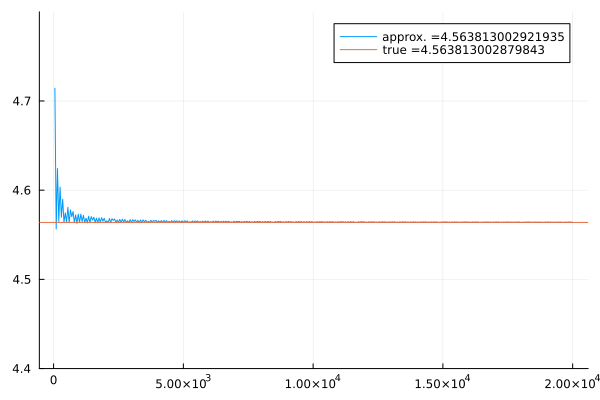

┌ Warning: attempting to remove probably stale pidfile
│   path = /Users/xiang/.jlassetregistry.lock
└ @ Pidfile /Users/xiang/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


InterruptException: InterruptException:

In [31]:
using Distributions, HaltonSequences, Interact, Plots

# change of varialbes
g(x) = exp((-1/3) * (x^2)) * sqrt(1+x^2)
x(t) = (2*t-1) / (t-t^2)                          # variable transformation
J(t) = (2*(t^2)-2*t+1) / ((t^2-t)^2)              # Jacobian
f(t) = g(x(t))*J(t)

every = 50
n_end = 20000

n_start = every
res_Halton = zeros(Int((n_end-n_start)/every) + 1)

hpt = Halton(2, length = n_end)

for n in n_start:every:n_end                   
    res = sum( f.(hpt[1:n]) ) / n
    res_Halton[Int((n-n_start)/every) + 1] = res
end


n = [n_start:every:n_end;]
plot(n, res_Halton, ylimit=[4.4, 4.8], label="approx. =$(res_Halton[end])") 
hline!([4.5638130028798430179261736288958], label="true =4.563813002879843") |> display

allgrids = Int(n_end/every)

@manipulate for grid in 1:allgrids 
    n1   = n[1:grid]  # the max of grid is allgrids
    res1 = res_Halton[1:grid]
    plot(n1, res1, ylimit=[4.4, 4.8], label="approx. =$(res1[end])")
    hline!([4.5638130028798430179261736288958], label="  true =4.563813002879843") 
end

---

## 
Consider the following integration problem:
\begin{align}
  I = \int_a^1 c\cdot x^{-k-1}(1-x)^{k+1}dx.
\end{align}
Assume $a = 10^{-5}$, $c=10^{-9}$, and $k=2$.

### Plot (multiple) graphs of the integrand to have a basic understanding of the problem. As you can see from the equation, the integrand may be tricky when $x$ approaches 0 and when $x$ approaches 1. Therefore, plot the graphs that highlight the integrand's shape near x=0 and x=1.

---

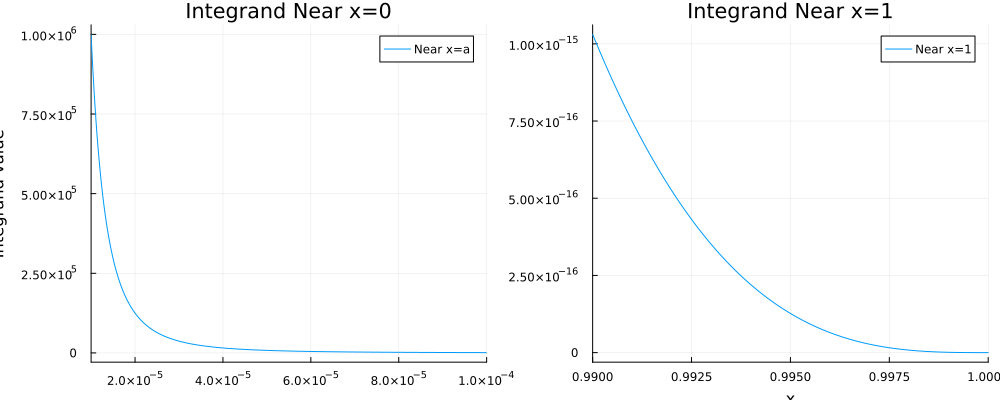

In [34]:
using Plots

# define the parameters and integrand function
a = 10^-5
c = 10^-9
k = 2
function integrand(x)
    return c * x^(-k-1) * (1-x)^(k+1)
end

# generate x values for plotting near a and near 1
x_near_a = range(a, 10^-4, length = 500)
x_near_1 = range(0.99, 1, length = 500)

# plot the function near x=a and x=1
plot1 = plot(x_near_a, integrand.(x_near_a), label="Near x=a", title="Integrand Near x=0", xlabel="x", ylabel="Integrand value", xlims=(a, 10^-4))
plot2 = plot(x_near_1, integrand.(x_near_1), label="Near x=1", title="Integrand Near x=1", xlabel="x", xlims=(0.99, 1))

# display plots
plot(plot1, plot2, layout=(1,2), size=(1000, 400))

---

# Use the Gauss-Legendre rule to compute the integral. How many nodes are required to have a stable solution (say, five digits after the decimal point are unchanged) ? (Hint: A lot of nodes)

We can map the interval $(a,1)$ by letting $x(t) = \frac{a+1}{2} + \frac{1-a}{2}t$, where $t \in [-1,1]$, and we can obtain

\begin{align}
I &= \int_a^1 c\cdot x^{-k-1}(1-x)^{k+1}dx \\
    &= \int_{-1}^1 \underbrace{c \cdot [x(t)]^{-k-1} [1-x(t)]^{k+1}}_{f(t)} \underbrace{\left(\frac{1-a}{2}\right)}_{\text{Jacobian}} dt
\end{align}

In [24]:
using FastGaussQuadrature, Distributions

# define GLintg function
function GLInteg(a = 10^-5, c = 10^-9, k = 2, n = 100000)
    
    # get Gauss-Legendre weight and define g(x) and f(x)
    x, w = gausslegendre(n)
    g(x) = (a+1)/2 + (1-a)/2 * x
    jacobian = (1-a) / 2
    f(x) = c * (g(x))^(-k-1) * (1-g(x))^(k+1) * jacobian
    
    # compute the integral with GL rule
    integral = sum(w .* f.(x))
    
    return integral

end

# use GL rule to compute the integral
GLInteg()

4.999700036028699

---

### Use both of the Monte Carlo method (with pseudo random numbers) and Quasi-Monte Carlo method (with the Halton sequence) to compute the integral. How long does the sequences need to be in order to have a stable solution (2 digits after the decimal point)? Which method, MC or QMC, uses smaller values of $n$?
- Hint: A very long sequence.
- Hint: The following generates a Halton sequence of length 100 with the base number=2: `using HaltonSequences;` `lds=Halton(2,100)`.

In [49]:
using Random
Random.seed!(456)

# Monte Carlo method (set n = 500,000,000)
function monte_carlo_integration(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)
    u = rand(n)
    x = a .+ (b - a) .* u
    g_x = c .* x.^(-k-1) .* (1 .- x).^(k+1)
    jacobian = b - a
    return mean(g_x) * jacobian
end

@show monte_carlo_integration(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)

monte_carlo_integration(a = 10 ^ -5, b = 1, n = 500000000, c = 10 ^ -9, k = 2) = 4.9930069553101895


4.9930069553101895

In [50]:
using HaltonSequences
Random.seed!(456)

# Quasi-Monte Carlo method (set n = 500,000,000)
function quasi_monte_carlo_integration(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)
    lds = Halton(2, length = n)  # Generate Halton sequence with base number=2# Generate quasi-random numbers
    x = a .+ (b - a) .* lds  # Transform to [a,b]
    g_x = c .* x.^(-k-1) .* (1 .- x).^(k+1)  # Calculate the integrand
    jacobian = b - a  # Calculate the Jacobian of the transformation
    return mean(g_x) * jacobian  # Estimate the integral
end

# Test the function with n=10000
@show quasi_monte_carlo_integration(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)

quasi_monte_carlo_integration(a = 10 ^ -5, b = 1, n = 500000000, c = 10 ^ -9, k = 2) = 5.0018985346918905


5.0018985346918905

In [52]:
Random.seed!(456)

# Loop to find the minimum n such that 
every = 100000000  # Start with a smaller step to increase resolution
n_end = 700000000  # Smaller end value for initial tests

diff_limit = 0.01
stable_number_of_node = 0

for n in every:every:n_end

    # estimate the integral by both methods, and compute the difference
    MC = monte_carlo_integration_with_transformation(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)
    QMC = quasi_monte_carlo_integration(a = 10^-5, b = 1, n = 500000000, c = 10^-9, k = 2)
    residual = abs(MC - QMC)
    
    
    if residual < diff_limit 
        stable_number_of_node = n
        break
    end
    
end

@show stable_number_of_node
quasi_monte_carlo_integration(n = stable_number_of_node)


stable_number_of_node = 100000000


5.004913564224059

---

### Julia provides a package `QuadGK.jl` which has a function `quadgk()` that uses *adaptive quadratures* to do one-dimensional numerical integration. Use `using Pkg; Pkg.add("QuadGK.jl")` to install it, and `using QuadGK` to call it.
- Please read Section 1.3 on `Lec4 Numerical Integration - class.ipynb` to understand what is adaptive quadratures.
- Use `quadgk()` function to compute the integration.

In [45]:
using QuadGK

# define the parameters and integrand
a = 10^-5
c = 10^-9
k = 2
function integrand(x)
    return c * x^(-k-1) * (1-x)^(k+1)
end

# perform the integration using adaptive quadrature
result, error = quadgk(integrand, a, 1)

# print out the estimated result and the estimated error
println("Integral result: ", result)
println("Estimated error: ", error)


Integral result: 4.999700036038788
Estimated error: 8.454822191315856e-10


---

### You tried several methods to calculate the integration: The Gauss-Legendre method, the quasi-Monte Carlo method using the Halton sequence, the Monte Carlo method using random draws, and the adaptive quadrature method. How would you rank the methods from the most efficient (in terms of using a smaller number of draws/points, which usually translates to shorter run time) to the least efficient? Please explain the possible reasons behind the most and the least efficient methods.

The rank of the methods according to the efficiency is: adaptive quadrature, Gauss-Legendre, Monte Carlo using random draws, and quasi-Monte Carlo using Halton sequence. The potential reason behind the efficiency of adaptive quadrature should be that it adapt to the shape of the estimated integral, thus leading to more quick convergence; while the inefficiency behind quasi-Monte Carlo random draws is because that it completely lacks of information update, namely, completely random drawing, leading to its inaccuracy before large size of nodes.

---